In [1]:
"""
Generator function to generate exterior profile and truss framing training
sets
"""

'\nGenerator function to generate exterior profile and truss framing training\nsets\n'

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rand
import os
import pickle
from matplotlib import collections  as mc

GENERATE MODELS

In [3]:
"""
Node values:
0: support
1: intermediate

Edge weights:
0: empty - for negative edges
1: profile
2: top chord
3: bottom chord
4: web
"""

'\nNode values:\n0: support\n1: intermediate\n\nEdge weights:\n0: empty - for negative edges\n1: profile\n2: top chord\n3: bottom chord\n4: web\n'

In [4]:
def add_node_feature(nodes):
    """
    Add node features to x and y dimensions

    Input:
    nodes: list of node coordinates

    Output:
    _x: node feature array with [x, y, feature]
    """
    _x = []
    i = 0
    max_len = len(nodes)

    for i in range(max_len):
        if i == 0 or i == (max_len - 1):
            _x.append([nodes[i][0], nodes[i][1], 0])
        else:
            _x.append([nodes[i][0], nodes[i][1], 1])

    return _x

In [5]:
def add_node_feature_ft(nodes):
    """
    Add node features to x and y dimensions for flat trusses

    Input:
    nodes: list of node coordinates

    Output:
    _x: node feature array with [x, y, feature]
    """
    _x = []
    i = 0
    max_len = len(nodes)

    for i in range(max_len):
        _x.append([nodes[i][0], nodes[i][1], 1])

    return _x

In [6]:
def split_edge_nodes(edges):
    """
    Function to split start and end nodes into two lists - required for pytoch
    geometric

    Input:
    edges: array of lists with start and end node pairs

    Output:
    _adj: array of lists with start nodes and end nodes split into separate
          arrays. Also add undirected edges (reverse)
    """
    _adj = []
    start_nodes = []
    end_nodes = []

    # split nodes
    for i in edges:
        start_nodes.append(i[0])
        end_nodes.append(i[1])

    _adj = [start_nodes, end_nodes]
  
    return _adj

In [7]:
def edge_data(edges, features):
    """
    Function to add edge features to nodes to sort edges in COO format

    Input:
    edges: array of lists with start and end node pairs
    features: list of features in order of edges

    Output:
    _adj: array of list with start and end nodes
    _f: feature array
    """

    _data = []
    _edges = []
    _f = []

    # add features to edges and sort
    for i in range(len(features)):
        _data.append([edges[i][0], edges[i][1], features[i]])

    # add undirected edges
    for i in range(len(features)):
        _data.append([edges[i][1], edges[i][0], features[i]])

    _data.sort()

    # split edges and features
    for i in _data:
        _edges.append([i[0], i[1]])
        _f.append(i[2])

    return _edges, _f

In [8]:
def gen_nodes(bc_nodes, bc_seg, tc_nodes, tc_seg, pitch):
    """
    Function generates truss nodes given the inputs

    Inputs:
    bc_nodes: number of nodes for bottom chord
    bc_seg: number of member segments
    tc_nodes: number of nodes for top chord excluding start and end node
    tc_seg: number of member segments

    Output:
    _nodes: array of x, y coordinates sorted in COO format
    """
    _nodes = [[0,0]]

    # get bottom chord nodes
    x = 0
    y = 0

    for i in range(bc_nodes-1):
        x += bc_seg
        _nodes.append([x, y])

    # get top chord nodes
    x = 0
    y = 0

    for i in range(tc_nodes):
        x += tc_seg
        if i <= 1:
            y = (x * pitch) / 12
        else:
            y = (tc_seg * pitch) / 12
        _nodes.append([x, y])
    
    _nodes.sort()

    return _nodes

In [9]:
def small_fink_truss(pitch, span):
    """
    Function generates a fink truss given pitch and span 15-30

    Inputs:
    pitch: top chord roof pitch in inches/foot
    span: bearing length of truss

    Outputs:
    x_a: node features for profile
    a_adj: outline adjacency matrix - perimeter of truss without webs
    a_f: edge weights
    x_s: node features for structural frame
    s_adj: structural frame adjacency matrix - chords and webs
    s_f: edge weidghts of structure see values
    """
    a_adj = []
    a_f = []
    s_adj = []
    s_f = []

    # generate nodes
    bc_nodes = 4
    tc_nodes = 3

    bc_seg = span / 3
    tc_seg = span / 4

    nodes = gen_nodes(bc_nodes, bc_seg, tc_nodes, tc_seg, pitch)

    x_s = add_node_feature(nodes)
    x_a = [x_s[0], x_s[3], x_s[6]]

    # arch edges - hard code
    a_adj=[[0, 1], [1, 2], [0, 2]]

    # arch edge features - hard code
    a_f = [1, 1, 1]
    
    a_adj, a_f = edge_data(a_adj, a_f)
    a_adj = split_edge_nodes(a_adj)

    # struct edges - hard code
    s_adj = [[0, 2], [2, 4], [4, 6], [0, 1], [1, 3], [3, 5], [5, 6], [1, 2], [2, 3], [3, 4], [4, 5]]

    # struct features - hard code
    s_f = [3, 3, 3, 2, 2, 2, 2, 4, 4, 4, 4]
    
    s_adj, s_f = edge_data(s_adj, s_f)
    s_adj = split_edge_nodes(s_adj)
  

    return x_a, a_adj, a_f, x_s, s_adj, s_f

In [10]:
def med_std_truss(pitch, span):
    """
    Function generates a standard medium truss given pitch and span 31-40

    Inputs:
    pitch: top chord roof pitch in inches/foot
    span: bearing length of truss

    Outputs:
    x_a: node features for profile
    a_adj: outline adjacency matrix - perimeter of truss without webs
    a_f: edge weights
    x_s: node features for structural frame
    s_adj: structural frame adjacency matrix - chords and webs
    s_f: edge weidghts of structure see values
    """
    a_adj = []
    a_f = []
    s_adj = []
    s_f = []

    # generate nodes
    bc_nodes = 5
    tc_nodes = 3

    bc_seg = span / 4
    tc_seg = span / 4

    nodes = gen_nodes(bc_nodes, bc_seg, tc_nodes, tc_seg, pitch)

    x_s = add_node_feature(nodes)
    x_a = [x_s[0], x_s[4], x_s[7]]

    # arch edges - hard code
    a_adj=[[0, 1], [1, 2], [0, 2]]

    # arch edge features - hard code
    a_f = [1, 1, 1]
    
    a_adj, a_f = edge_data(a_adj, a_f)
    a_adj = split_edge_nodes(a_adj)

    # struct edges - hard code
    s_adj = [[0, 1], [1, 3], [3, 5], [5, 7], [0, 2], [2, 4], [4, 6], [6, 7], [1, 2], [2, 3], [3, 4], [3, 6], [5, 6]]

    # struct features - hard code
    s_f = [3, 3, 3, 3, 2, 2, 2, 2, 4, 4, 4, 4, 4]
    
    s_adj, s_f = edge_data(s_adj, s_f)
    s_adj = split_edge_nodes(s_adj)
  

    return x_a, a_adj, a_f, x_s, s_adj, s_f

In [11]:
def dbl_fink_truss(pitch, span):
    """
    Function generates a double fink truss given pitch and span 41-50

    Inputs:
    pitch: top chord roof pitch in inches/foot
    span: bearing length of truss

    Outputs:
    x_a: node features for profile
    a_adj: outline adjacency matrix - perimeter of truss without webs
    a_f: edge weights
    x_s: node features for structural frame
    s_adj: structural frame adjacency matrix - chords and webs
    s_f: edge weidghts of structure see values
    """
    a_adj = []
    a_f = []
    s_adj = []
    s_f = []

    # generate nodes
    bc_nodes = 6
    tc_nodes = 5

    bc_seg = span / 5
    tc_seg = span / 6

    nodes = [[0,0]]

    # get bottom chord nodes
    x = 0
    y = 0

    for i in range(bc_nodes-1):
        x += bc_seg
        nodes.append([x, y])

    # get top chord nodes
    x = 0
    y = 0

    for i in range(tc_nodes):
        x += tc_seg
        if i <= 2:
            y = (x * pitch) / 12
        else:
            y = ((span-x) * pitch) / 12
        nodes.append([x, y])
    
    nodes.sort()

    x_s = add_node_feature(nodes)
    x_a = [x_s[0], x_s[5], x_s[10]]

    # arch edges - hard code
    a_adj=[[0, 1], [1, 2], [0, 2]]

    # arch edge features - hard code
    a_f = [1, 1, 1]
    
    a_adj, a_f = edge_data(a_adj, a_f)
    a_adj = split_edge_nodes(a_adj)

    # struct edges - hard code
    s_adj = [[0, 2], [2, 4], [4, 6], [6, 8], [8, 10], [0, 1], [1, 3], [3, 5], [5, 7], [7, 9], [9, 10], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9]]

    # struct features - hard code
    s_f = [3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4]
    
    s_adj, s_f = edge_data(s_adj, s_f)
    s_adj = split_edge_nodes(s_adj)
  

    return x_a, a_adj, a_f, x_s, s_adj, s_f

In [12]:
def large_flat_truss(span):
    """
    Function generates a small flat truss 16" deep with spans 20-30 ft
    Hard coded to just complete faster.

    Inputs:
    span: bearing length of truss in feet

    Outputs:
    x_a: node features for profile
    a_adj: outline adjacency matrix - perimeter of truss without webs
    a_f: edge weights
    x_s: node features for structural frame
    s_adj: structural frame adjacency matrix - chords and webs
    s_f: edge weidghts of structure see values
    """
    
    a_adj = []
    a_f = []
    s_adj = []
    s_f = []

    # generate nodes
    depth = 2
    seg = 11
    seg_len = span/seg

    bc_nodes = tc_nodes = seg + 1

    # get nodes
    x = 0
    y = 0
    y1 = depth

    nodes = [[0,0], [0, y1]]

    for i in range(bc_nodes-1):
        x += seg_len
        nodes.append([x, y])
        nodes.append([x, y1])
    nodes.sort()

    # node features
    x_s = add_node_feature_ft(nodes)
    x_s[0][2] = x_s[-2][2] = 0
    x_a = [x_s[0], x_s[1], x_s[-2], x_s[-1]]

    # arch edges - hard code
    a_adj=[[0, 1], [1, 3], [3, 2], [0, 2]]

    # arch edge features - hard code
    a_f = [1, 1, 1, 1]
    
    a_adj, a_f = edge_data(a_adj, a_f)
    a_adj = split_edge_nodes(a_adj)

    # struct edges - hard code
    s_adj = [[0, 2], [2, 4], [4, 6], [6, 8], [8, 10], [10, 12], [12, 14], [14, 16], [16, 18], [18, 20], [20, 22], 
             [1, 3], [3, 5], [5, 7], [7, 9], [9, 11], [11, 13], [13, 15], [15, 17], [17, 19], [19, 21], [21, 23], 
             [0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [10, 11], [12, 13], [14, 15], [16, 17], [18, 19], [20, 21], [22, 23],
             [1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [12, 15], [14, 17], [16, 19], [18, 21], [20, 23]]

    # struct features - hard code
    s_f = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
           4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
    
    s_adj, s_f = edge_data(s_adj, s_f)
    s_adj = split_edge_nodes(s_adj)
  

    return x_a, a_adj, a_f, x_s, s_adj, s_f
    

In [13]:
def small_flat_truss(span):
    """
    Function generates a large flat truss 24" deep with spans 10-18 ft
    Hard coded to just complete faster.

    Inputs:
    span: bearing length of truss in feet

    Outputs:
    x_a: node features for profile
    a_adj: outline adjacency matrix - perimeter of truss without webs
    a_f: edge weights
    x_s: node features for structural frame
    s_adj: structural frame adjacency matrix - chords and webs
    s_f: edge weidghts of structure see values
    """
    
    a_adj = []
    a_f = []
    s_adj = []
    s_f = []

    # generate nodes
    depth = 1.33
    seg = 5
    seg_2 = span/seg
    seg_1 = seg_2 / 2

    bc_nodes = 6
    tc_nodes = 7

    # get nodes
    x = 0
    y = 0
    y1 = depth

    nodes = [[0,0]]

    for i in range(bc_nodes-1):
        x += seg_2
        nodes.append([x, y])
    

    nodes.append([0, y1])

    x = 0
    for i in range(tc_nodes-1):
        if i == 0 or i == 5:
            x += seg_1
        else:
            x += seg_2
        nodes.append([x, y1])

    # node features
    x_s = add_node_feature_ft(nodes)
    x_s[0][2] = x_s[5][2] = 0
    x_a = [x_s[0], x_s[6], x_s[5], x_s[12]]

    # arch edges - hard code
    a_adj=[[0, 1], [1, 3], [3, 2], [0, 2]]

    # arch edge features - hard code
    a_f = [1, 1, 1, 1]
    
    a_adj, a_f = edge_data(a_adj, a_f)
    a_adj = split_edge_nodes(a_adj)

    # struct edges - hard code
    s_adj = [[0,1], [1,2], [2,3], [3,4], [4,5], [6,7], [7,8], [8,9], [9,10], [10,11], [11,12],
             [0,6], [0,7], [7,1], [1,8], [8,2], [2,9], [9,3], [3,10], [10,4], [4,11], [11,5], [5,12]]

    # struct features - hard code
    s_f = [3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
           4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
    
    s_adj, s_f = edge_data(s_adj, s_f)
    s_adj = split_edge_nodes(s_adj)
  

    return x_a, a_adj, a_f, x_s, s_adj, s_f
    

RENDER

In [14]:
def render_graph(nodes, edges, edge_features):
    """
    Function to plot building model from edge and node arrays
    Parameters:
    nodes: node list with coords
    edges: arch or struct edges
    edge_features: values for edge weights

    Ouput: 2d plot of edges and nodes
    """
    scale = 80
    fig , ax = plt.subplots()
    ax.set_aspect('equal')
  
    start_nodes = edges[0]
    end_nodes = edges[1]

    # plot edges
    for i in range(len(start_nodes)):
        start_node_data= nodes[start_nodes[i]]
        end_node_data = nodes[end_nodes[i]]
        edge_weight = edge_features[i] 
      
        x1 = start_node_data[0]
        y1 = start_node_data[1]
        x2 = end_node_data[0]
        y2 = end_node_data[1]

        _x = [x1, x2]
        _y = [y1, y2]

        if edge_weight == 1:
            plt.plot(_x, _y, 'g')
        elif edge_weight == 2:
            plt.plot(_x, _y, 'b')
        elif edge_weight == 3:
            plt.plot(_x, _y, 'r')
        elif edge_weight == 4:
            plt.plot(_x, _y, 'm')
        else:
            raise ValueError("edge_weight out of range")
    
    # plot points
    for i in range(len(nodes)):
        _x = nodes[i][0]
        _y = nodes[i][1]
        _f = nodes[i][2]

        if _f == 0:
            plt.plot(_x, _y, 'or')
        elif _f == 1:
            plt.plot(_x, _y, 'ok')
        else:
            raise ValueError("node features out of range")
        
    plt.show()

In [15]:
x_a, a_adj, a_f, x_s, s_adj, s_f = small_fink_truss(5, 34)

In [16]:
x_a, a_adj, a_f, x_s, s_adj, s_f = med_std_truss(4, 35)

In [17]:
x_a, a_adj, a_f, x_s, s_adj, s_f = dbl_fink_truss(6, 60)

In [18]:
x_a, a_adj, a_f, x_s, s_adj, s_f = small_flat_truss(15)

In [19]:
x_a, a_adj, a_f, x_s, s_adj, s_f = large_flat_truss(25)

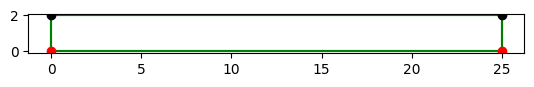

In [20]:
render_graph(x_a, a_adj, a_f)

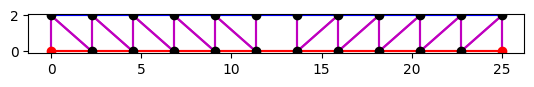

In [21]:
render_graph(x_s, s_adj, s_f)

In [22]:
print(f"s_adj:{len(s_adj[0])}  s_f:{len(s_f)}")

s_adj:88  s_f:88


In [23]:
len(x_s)

24

In [24]:
s_adj

[[0,
  0,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  13,
  13,
  13,
  14,
  14,
  14,
  14,
  15,
  15,
  15,
  15,
  16,
  16,
  16,
  16,
  17,
  17,
  17,
  17,
  18,
  18,
  18,
  18,
  19,
  19,
  19,
  19,
  20,
  20,
  20,
  20,
  21,
  21,
  21,
  21,
  22,
  22,
  23,
  23,
  23],
 [1,
  2,
  0,
  2,
  3,
  0,
  1,
  3,
  4,
  1,
  2,
  4,
  5,
  2,
  3,
  5,
  6,
  3,
  4,
  6,
  7,
  4,
  5,
  7,
  8,
  5,
  6,
  8,
  9,
  6,
  7,
  9,
  10,
  7,
  8,
  10,
  11,
  8,
  9,
  11,
  12,
  9,
  10,
  13,
  10,
  13,
  14,
  15,
  11,
  12,
  15,
  12,
  15,
  16,
  17,
  12,
  13,
  14,
  17,
  14,
  17,
  18,
  19,
  14,
  15,
  16,
  19,
  16,
  19,
  20,
  21,
  16,
  17,
  18,
  21,
  18,
  21,
  22,
  23,
  18,
  19,
  20,
  23,
  20,
  23,
  20,
  21,
  22]]

In [25]:
len(s_adj[0])

88

In [26]:
len(s_f)

88

In [27]:
ww = np.zeros((24, 24))
ww = ww.flatten()
ww.shape

(576,)

In [28]:
zz = np.concatenate((ww, ww, ww))
zz.shape

(1728,)

## GENERATE DATA

In [29]:
def gen_data(number, type_data):
    """
    Function to generate training pairs of five truss types of various lengths.
    Each truss type should generally have the same number of samples

    Input:
    number: number of samples to generate
    type_data: either 'test' or 'train' for data set name

    Output:
    data: array of input and label data pairs
    """
    save_file_path = '/content/drive/MyDrive/framebot_V5/data'
    # save_file_path = '/content/drive/MyDrive/framebot_V5.1/data'
    data = []

    # class identification for training - one hot
    """
    sft = [1, 0, 0, 0, 0]
    mst = [0, 1, 0, 0, 0]
    dft = [0, 0, 1, 0, 0]
    sflt = [0, 0, 0, 1, 0]
    lflt = [0, 0, 0, 0, 1]
    """

    # classes for graph network - won't work for other model
    
    sft = 0
    mst = 1
    dft = 2
    sflt = 3
    lflt = 4
    

    cat_split = int(number / 5)
    
    for i in range(cat_split):
        span = rand.uniform(15, 30)
        pitch = rand.uniform(3, 6)
        x_a = a_adj = a_f = x_s = s_adj = s_f = []

        x_a, a_adj, a_f, x_s, s_adj, s_f = small_fink_truss(pitch, span)
        data.append([x_a, a_adj, a_f, x_s, s_adj, s_f, sft])
    
    for i in range(cat_split):
        span = rand.uniform(31, 40)
        pitch = rand.uniform(3, 6)
        x_a = a_adj = a_f = x_s = s_adj = s_f = []

        x_a, a_adj, a_f, x_s, s_adj, s_f = med_std_truss(pitch, span)
        data.append([x_a, a_adj, a_f, x_s, s_adj, s_f, mst])

    for i in range(cat_split):
        span = rand.uniform(41, 50)
        pitch = rand.uniform(4, 6)
        x_a = a_adj = a_f = x_s = s_adj = s_f = []

        x_a, a_adj, a_f, x_s, s_adj, s_f = dbl_fink_truss(pitch, span)
        data.append([x_a, a_adj, a_f, x_s, s_adj, s_f, dft])

    for i in range(cat_split):
        span = rand.uniform(10, 18)
        x_a = a_adj = a_f = x_s = s_adj = s_f = []

        x_a, a_adj, a_f, x_s, s_adj, s_f = small_flat_truss(span)
        data.append([x_a, a_adj, a_f, x_s, s_adj, s_f, sflt])

    for i in range(cat_split):
        span = rand.uniform(20, 30)
        x_a = a_adj = a_f = x_s = s_adj = s_f = []

        x_a, a_adj, a_f, x_s, s_adj, s_f = large_flat_truss(span)
        data.append([x_a, a_adj, a_f, x_s, s_adj, s_f, lflt])

    data = np.array(data, dtype=object)
    file = save_file_path + "/" + type_data + "_data.npy"
    np.save(file, data)

In [30]:
#gen_data(30000, 'train')

In [31]:
# gen_data(10, 'test_gnn')

# LOAD AND CHECK DATA

In [180]:
train_data = '/content/drive/MyDrive/framebot_V5/data/train_data.npy'
test_data = '/content/drive/MyDrive/framebot_V5.1/data/test_gnn_data.npy'

In [181]:
data = np.load(test_data, allow_pickle=True)

In [182]:
len(data)

10

In [276]:
data[0]


array([list([[0, 0, 0], [14.53333813980943, 4.694188112143081, 1], [29.06667627961886, 0, 0]]),
       list([[0, 0, 1, 1, 2, 2], [1, 2, 0, 2, 0, 1]]),
       list([1, 1, 1, 1, 1, 1]),
       list([[0, 0, 0], [7.266669069904715, 2.3470940560715405, 1], [9.688892093206286, 0, 1], [14.53333813980943, 4.694188112143081, 1], [19.377784186412573, 0, 1], [21.800007209714146, 2.3470940560715405, 1], [29.06667627961886, 0, 0]]),
       list([[0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6], [1, 2, 0, 2, 3, 0, 1, 3, 4, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 4, 5]]),
       list([2, 3, 2, 4, 2, 3, 4, 4, 3, 2, 4, 4, 2, 3, 4, 4, 3, 2, 4, 2, 3, 2]),
       0], dtype=object)

In [277]:
truss = data[0]

x_a = truss[0]
a_adj = truss[1]
a_e = truss[2]
x_s = truss[3]
s_adj = truss[4]
s_e = truss[5]
t_class = truss[6]

In [278]:
t_class

0

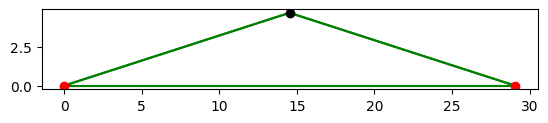

In [279]:
render_graph(x_a, a_adj, a_e)

In [266]:
x_a

[[0, 0, 0], [0, 2, 1], [23.959442729415674, 0, 0], [23.959442729415674, 2, 1]]

In [267]:
a_adj

[[0, 0, 1, 1, 2, 2, 3, 3], [1, 2, 0, 3, 0, 3, 1, 2]]

In [268]:
a_e

[1, 1, 1, 1, 1, 1, 1, 1]

In [269]:
print(f"a_adj:{len(a_adj[0])}  a_f:{len(a_e)}")

a_adj:8  a_f:8


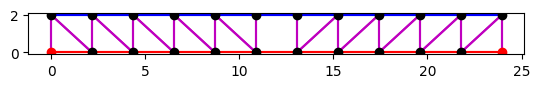

In [270]:
render_graph(x_s, s_adj, s_e)

In [271]:
x_s

[[0, 0, 0],
 [0, 2, 1],
 [2.1781311572196067, 0, 1],
 [2.1781311572196067, 2, 1],
 [4.356262314439213, 0, 1],
 [4.356262314439213, 2, 1],
 [6.53439347165882, 0, 1],
 [6.53439347165882, 2, 1],
 [8.712524628878427, 0, 1],
 [8.712524628878427, 2, 1],
 [10.890655786098034, 0, 1],
 [10.890655786098034, 2, 1],
 [13.06878694331764, 0, 1],
 [13.06878694331764, 2, 1],
 [15.246918100537247, 0, 1],
 [15.246918100537247, 2, 1],
 [17.425049257756854, 0, 1],
 [17.425049257756854, 2, 1],
 [19.60318041497646, 0, 1],
 [19.60318041497646, 2, 1],
 [21.781311572196067, 0, 1],
 [21.781311572196067, 2, 1],
 [23.959442729415674, 0, 0],
 [23.959442729415674, 2, 1]]

In [272]:
s_adj

[[0,
  0,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  9,
  9,
  9,
  9,
  10,
  10,
  10,
  10,
  11,
  11,
  11,
  12,
  12,
  12,
  12,
  13,
  13,
  13,
  14,
  14,
  14,
  14,
  15,
  15,
  15,
  15,
  16,
  16,
  16,
  16,
  17,
  17,
  17,
  17,
  18,
  18,
  18,
  18,
  19,
  19,
  19,
  19,
  20,
  20,
  20,
  20,
  21,
  21,
  21,
  21,
  22,
  22,
  23,
  23,
  23],
 [1,
  2,
  0,
  2,
  3,
  0,
  1,
  3,
  4,
  1,
  2,
  4,
  5,
  2,
  3,
  5,
  6,
  3,
  4,
  6,
  7,
  4,
  5,
  7,
  8,
  5,
  6,
  8,
  9,
  6,
  7,
  9,
  10,
  7,
  8,
  10,
  11,
  8,
  9,
  11,
  12,
  9,
  10,
  13,
  10,
  13,
  14,
  15,
  11,
  12,
  15,
  12,
  15,
  16,
  17,
  12,
  13,
  14,
  17,
  14,
  17,
  18,
  19,
  14,
  15,
  16,
  19,
  16,
  19,
  20,
  21,
  16,
  17,
  18,
  21,
  18,
  21,
  22,
  23,
  18,
  19,
  20,
  23,
  20,
  23,
  20,
  21,
  22]]

In [273]:
s_e

[4,
 3,
 4,
 4,
 2,
 3,
 4,
 4,
 3,
 2,
 4,
 4,
 2,
 3,
 4,
 4,
 3,
 2,
 4,
 4,
 2,
 3,
 4,
 4,
 3,
 2,
 4,
 4,
 2,
 3,
 4,
 4,
 3,
 2,
 4,
 4,
 2,
 3,
 4,
 4,
 3,
 2,
 4,
 2,
 3,
 4,
 3,
 4,
 2,
 4,
 2,
 3,
 4,
 3,
 4,
 4,
 2,
 4,
 2,
 3,
 4,
 3,
 4,
 4,
 2,
 4,
 2,
 3,
 4,
 3,
 4,
 4,
 2,
 4,
 2,
 3,
 4,
 3,
 4,
 4,
 2,
 4,
 2,
 3,
 4,
 4,
 2,
 4]

In [274]:
print(f"s_adj:{len(s_adj[0])}  s_f:{len(s_e)}")

s_adj:88  s_f:88
